# Stock Price Prediction using LSTM (Long Short-Term Memory)

In order to support the investors on stock market predictions, this notebooks use the architecture of RNN, LSTM, to analyze the NVIDIA evaluation.

* Dataset: https://finance.yahoo.com/quote/NVDA/history/
* Team:
    - Gabriel dos Santos Lima
    - Augusto César Silvestre da Silva
    - Guilherme Lucas T. Silva

In [241]:
import pandas as pd 
import numpy as np
import tensorflow
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## Importing dataset
First of all, we need to import the dataset of history stock prices of NVIDIA

In [242]:
data_price = pd.read_csv('./data.csv', delimiter=",")
data_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    250 non-null    object 
 1   Open    250 non-null    float64
 2   High    250 non-null    float64
 3   Low     250 non-null    float64
 4   Close   250 non-null    float64
 5   Volume  250 non-null    object 
dtypes: float64(4), object(2)
memory usage: 11.8+ KB


In [243]:
data_price.head(5)

,Date,Open,High,Low,Close,Volume
0,01/27/2025,124.80,128.40,116.70,118.42,"818,830,938"
1,01/24/2025,148.37,148.97,141.88,142.62,"234,657,594"
2,01/23/2025,145.05,147.23,143.72,147.22,"155,915,500"
3,01/22/2025,144.66,147.79,143.67,147.07,"237,651,391"
4,01/21/2025,139.16,141.83,137.09,140.83,"197,748,984"


## Exploration
This step aims to explore the dataset and gather some informations about it

In [244]:
def str_to_date(date: str):
    return pd.to_datetime(date)

In [245]:
data_price['Date'] = data_price['Date'].apply(str_to_date)

prices_by_month = data_price.groupby(data_price['Date'].dt.month)['Close'].count()
prices_by_month = pd.DataFrame(zip(prices_by_month.index, prices_by_month.array), columns=['month', 'count'])

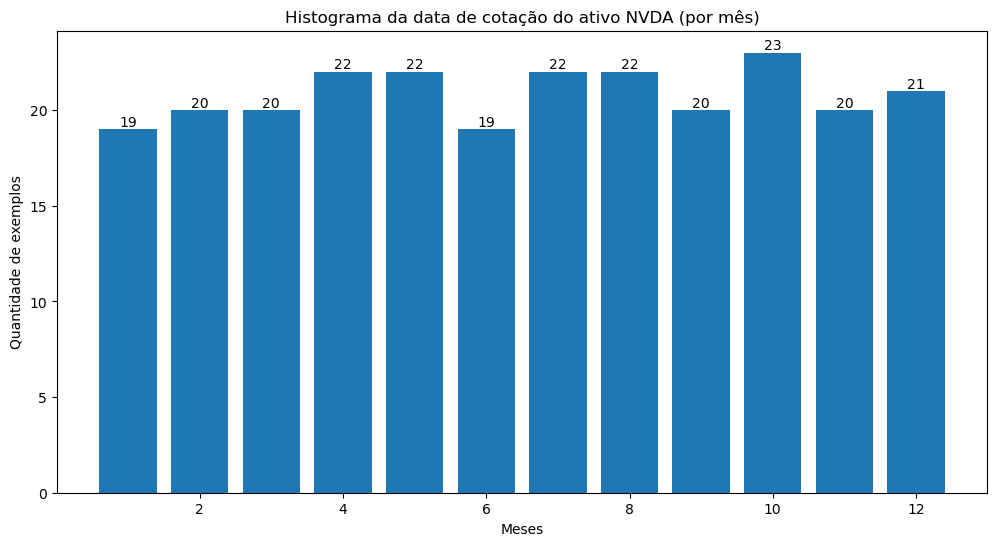

In [246]:
plt.figure(figsize=(12,6))
plt.title("Histograma da data de cotação do ativo NVDA (por mês)")
plt.xlabel("Meses")
plt.ylabel("Quantidade de exemplos")
bars = plt.bar(prices_by_month['month'], prices_by_month['count'])
plt.bar_label(bars, fontsize=10)
plt.show()

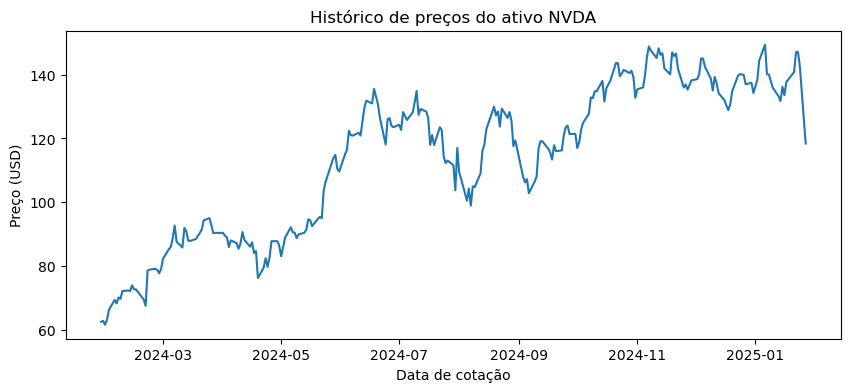

In [247]:
plt.figure(figsize=(10,4))
plt.plot(data_price['Date'], data_price['Close'])
plt.title("Histórico de preços do ativo NVDA")
plt.xlabel('Data de cotação')
plt.ylabel("Preço (USD)")
plt.show()

## Pre-processing

Removing missing values

In [248]:
sanitized_price_data = data_price.dropna()
print(f"{len(sanitized_price_data) - len(data_price)} exemplos foram removidos.")

0 exemplos foram removidos.


Removing unused columns

In [249]:
if 'Open' in sanitized_price_data:
    sanitized_price_data['price'] = sanitized_price_data['Close']
    sanitized_price_data = sanitized_price_data.drop(columns=['Open', 'Close', 'High', 'Low', 'Volume'])

sanitized_price_data.head(4)

,Date,price
0,2025-01-27,118.42
1,2025-01-24,142.62
2,2025-01-23,147.22
3,2025-01-22,147.07


In [250]:
sanitized_price_data = sanitized_price_data.rename(columns={'Date': 'date'})
sanitized_price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    250 non-null    datetime64[ns]
 1   price   250 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [251]:
sanitized_price_data = sanitized_price_data.set_index(['date'])
sanitized_price_data.head(4)

,price
date,
2025-01-27,118.42
2025-01-24,142.62
2025-01-23,147.22
2025-01-22,147.07


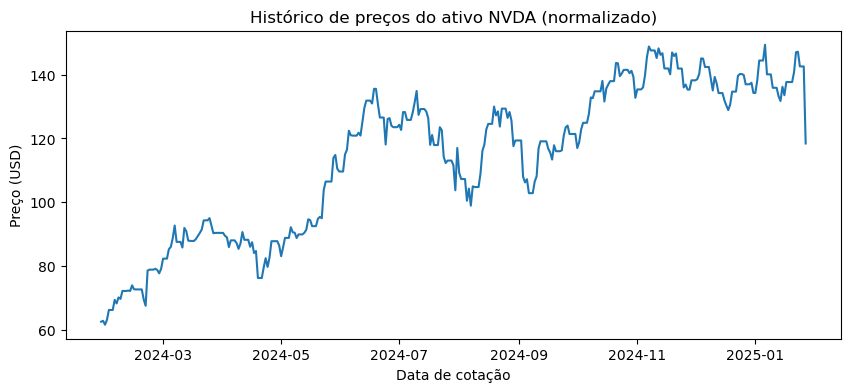

In [252]:
full_range = pd.date_range(sanitized_price_data.index.min(), sanitized_price_data.index.max())
sanitized_price_data = sanitized_price_data.reindex(full_range, method="bfill")

plt.figure(figsize=(10,4))
plt.plot(sanitized_price_data.index, sanitized_price_data['price'])
plt.title("Histórico de preços do ativo NVDA (normalizado)")
plt.xlabel('Data de cotação')
plt.ylabel("Preço (USD)")
plt.show()

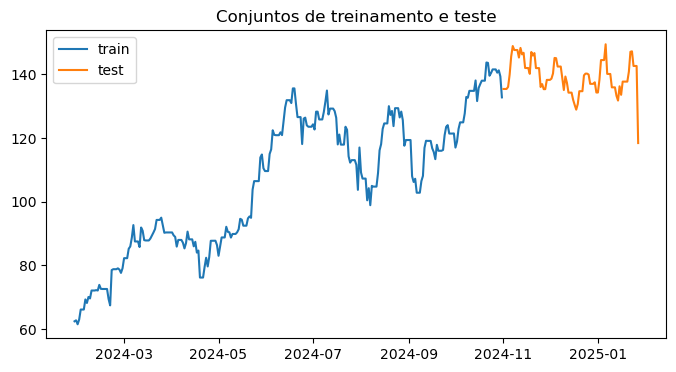

In [253]:
train = sanitized_price_data['2024-01':'2024-10']
test = sanitized_price_data['2024-11':]

plt.figure(figsize=(8,4))
plt.title("Conjuntos de treinamento e teste")
plt.plot(train.index, train['price'], label="train")
plt.plot(test.index, test['price'], label="test")
plt.legend()
plt.show()

We need to specify how many values to consider of each feature on the train dataset based on the history of NVIDIA stock price. 

Choose `look_back = 50` select fifty past features to be the target feature.  

In [254]:
def split_x_y_dataset(dataset, look_back=1):
    X, y = [], []
    for i in range(look_back, len(dataset)):
        X.append(dataset[i - look_back:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

In [255]:
look_back = 50
X_train, y_train = split_x_y_dataset(train['price'].values, look_back)
X_test, y_test = split_x_y_dataset(test['price'].values, look_back)

In [256]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Standard preprocessing using MinMaxScaler

In [257]:
# applying min-max scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

## Training

The neural network architecture used in this notebook is LSTM (Long Short Term Memory). LSTM is a kind of RNN (Recurrent Neural Network). The main difference between convetional RNNs and LSTMs is the time and the amount of data each architecture supports.

Let's prepare the model: 

In [258]:
model = keras.models.Sequential([
    keras.layers.LSTM(10, return_sequences=True, input_shape=[1, look_back]),
    keras.layers.Dense(10),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 1, 10)             2440      
                                                                 
 dense_12 (Dense)            (None, 1, 10)             110       
                                                                 
 dense_13 (Dense)            (None, 1, 1)              11        
                                                                 
Total params: 2,561
Trainable params: 2,561
Non-trainable params: 0
_________________________________________________________________


Training....

In [259]:
model.fit(X_train, y_train, epochs=50, batch_size=1)

Epoch 1/50
227/227 [==============================] - 3s 2ms/step - loss: 11260.9160
Epoch 2/50
227/227 [==============================] - 0s 1ms/step - loss: 6500.3076
Epoch 3/50
227/227 [==============================] - 0s 1ms/step - loss: 2328.2419
Epoch 4/50
227/227 [==============================] - 0s 1ms/step - loss: 621.5641
Epoch 5/50
227/227 [==============================] - 0s 2ms/step - loss: 305.3658
Epoch 6/50
227/227 [==============================] - 0s 1ms/step - loss: 215.6328
Epoch 7/50
227/227 [==============================] - 0s 1ms/step - loss: 108.4173
Epoch 8/50
227/227 [==============================] - 0s 1ms/step - loss: 71.5052
Epoch 9/50
227/227 [==============================] - 0s 2ms/step - loss: 53.1414
Epoch 10/50
227/227 [==============================] - 0s 2ms/step - loss: 44.8063
Epoch 11/50
227/227 [==============================] - 0s 2ms/step - loss: 42.4851
Epoch 12/50
227/227 [==============================] - 0s 2ms/step - loss: 36.7469
Ep

## Analysing the metrics

2/2 [==============================] - 0s 4ms/step


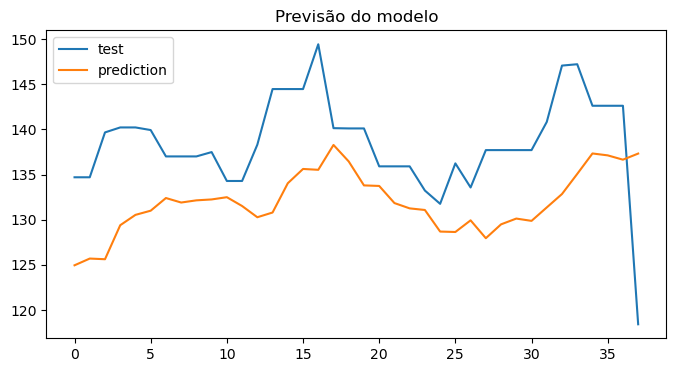

In [260]:
y_pred = model.predict(X_test).reshape(-1, 1)
# y_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(8,4))
plt.title("Previsão do modelo")
plt.plot(y_test, label="test")
plt.plot(y_pred, label="prediction")
plt.legend()
plt.show()

Finally, we need to plot some forecasting metrics (**Mean Absolute Error** and **Mean Squared Error**), in order to evaluate the trained model

In [261]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"MSE: {mse:.2f}\nMAE: {mae:.2f}")

MSE: 72.69
MAE: 7.52


**Conclusion:**: analyzing the metrics, the model followed the market trend for a long time compared to the real stock price values. 